In [19]:
###AVISO::: TEM QUE SUBSTITUIR O RANGE (linha 19) PARA NÃO TER DUPLICATAS, VISTO QUE O SITE RETORNA PARA A 
### PRIMEIRA PÁGINA SE ELE NÃO ACHAR A PÁGINA QUE PROCUROU

###Como tem anúncios patrocinados no site que estarão de volta ao topo em toda lista, temos que remover as duplicatas

#Biblioteca para a mineração de dados
from bs4 import BeautifulSoup

#Biblioteca para lidar com o HTTP 
import requests

#Biblioteca para exportar para csv
import pandas as pd

#Bibliotecas para visualização gráfica dos dados
import seaborn as sns 
import matplotlib.pyplot as plt

class Formatador:
    def __init__(self,df):
        self.df = df
        
    #Função para remover espaços brancos do dataframe
    def remover_espacos(self):
        df_obj = self.df.select_dtypes(['object'])
        self.df[df_obj.columns] = df_obj.apply(lambda x: x.str.strip())
    
    #Função para retirar o tipo de casa da coluna Titulo e separar em duas colunas novas
    def separar_tipo_casa(self):
        self.df[['Tipo_De_Casa', 'Nome']] = self.df['Titulo'].str.split(' ', 1, expand=True)
        self.df.drop(columns=['Titulo'], inplace=True)
    
    #Função para retirar o permonth da coluna Preço e transformar ela em numérica 
    def arrumar_preco(self):
        series = self.df['Preco']
        preco_numerico = series.str.strip('€per month')
        preco_sem_virgula = preco_numerico.str.replace(',', '')
        self.df['Preco_Em_Euros'] = pd.to_numeric(preco_sem_virgula)
        self.df.drop(columns=['Preco'], inplace=True)
    
    #Função para limpar a coluna localização e separar entre número da casa e lugar dela
    def limpar_localizacao(self):
        series = self.df['Localizacao']
        lista_numeros = []
        lista_localizacoes = []
    
        for entrada in series.str.split():
            lista_numeros.append(entrada[0])
            lista_localizacoes.append(entrada[3].strip('()'))
    
        self.df['Numero_Do_Imovel'] = pd.to_numeric(lista_numeros)
        self.df['Localizacao_Do_Imovel'] = lista_localizacoes
        self.df.drop(columns=['Localizacao'], inplace=True)

    #Função para separar as informações da coluna Tamanho
    def limpar_tamanho(self):
        series = self.df['Tamanho']
        lista_tamanhos = []
        lista_quartos = []
        lista_mobiliados = []

        for valor in series.str.split():
            lista_tamanhos.append(valor[0])
            lista_quartos.append(valor[1][-1])
    
            if ('Furnished' in valor[2]) & ('Upholstered' in valor[2]):
                lista_mobiliados.append('Mobiliado e Estofado')
    
            elif 'Furnished' in valor[2]:
                lista_mobiliados.append('Mobiliado')
    
            elif 'Upholstered' in valor[2]:
                lista_mobiliados.append('Estofado')
    
            else:
                lista_mobiliados.append('Sem Mobilia')
    
        self.df['Tamanho_Do_Imovel_Em_MetrosQuadrados'] = pd.to_numeric(lista_tamanhos)
        self.df['Numero_De_Quartos'] = pd.to_numeric(lista_quartos)
        self.df['Mobiliado'] = lista_mobiliados

        self.df.drop(columns=['Tamanho'], inplace=True)

    def dropar_duplicados(self):
        self.df = self.df.drop_duplicates(inplace=True)
    
    def realizar_formatacao(self):
        self.remover_espacos()
        self.separar_tipo_casa()
        self.arrumar_preco()
        self.limpar_localizacao()
        self.limpar_tamanho()
        self.dropar_duplicados()
        

#Criando o dataframe 
casas = pd.DataFrame(columns=['Titulo', 'Localizacao', 'Preco', 'Tamanho'])

#Contador para ir para as próximas páginas, mas é necessário contar quantas páginas tem e substituir no range
for contador in range(18):
    url = f'https://www.pararius.com/apartments/amsterdam/page-{contador}'

    page = requests.get(url)
    #Aqui é importante dar um print(page) para ver se o request é 200, ou seja, se deu certo o request para a página

    soup = BeautifulSoup(page.content, 'html.parser')
    lists = soup.find_all('section')

    for list in lists:
        title = list.find('a', class_ = 'listing-search-item__link--title').text.replace('\n', '')
        location = list.find('div', class_ = 'listing-search-item__sub-title').text.replace('\n', '')
        price = list.find('div', class_ = 'listing-search-item__price').text.replace('\n', '')
        size = list.find('ul', class_ = 'illustrated-features').text.replace('\n', '')
        info = [title, location, price, size]
        casas.loc[len(casas.index)] = info

formatador = Formatador(casas)
formatador.realizar_formatacao()

,Tipo_De_Casa,Nome,Preco_Em_Euros,Numero_Do_Imovel,Localizacao_Do_Imovel,Tamanho_Do_Imovel_Em_MetrosQuadrados,Numero_De_Quartos,Mobiliado
0,Apartment,Minervaplein,2850,1077,Apollobuurt,111,3,Mobiliado
1,Apartment,Hillegomstraat 32 2,2800,1058,Hoofddorppleinbuurt,85,4,Mobiliado
2,Apartment,Mary Zeldenruststraat 9 H,1800,1091,Oosterparkbuurt,60,3,Estofado
3,Apartment,Gerard Doustraat,1695,1072,Oude,44,2,Estofado
4,Apartment,Karthuizersplantsoen 9,3450,1015,Jordaan,161,3,Mobiliado
...,...,...,...,...,...,...,...,...
553,Apartment,Valeriusstraat 219 2,5500,1075,Willemspark,193,5,Estofado
554,Apartment,Amstelkade,2500,1078,Scheldebuurt,93,4,Mobiliado
555,Apartment,Linnaeusstraat,2300,1093,Dapperbuurt,63,2,Sem Mobilia
556,Apartment,Leliegracht 12 1,2250,1015,Grachtengordel-West,95,2,Mobiliado


<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 557
Data columns (total 8 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Tipo_De_Casa                          490 non-null    object
 1   Nome                                  490 non-null    object
 2   Preco_Em_Euros                        490 non-null    int64 
 3   Numero_Do_Imovel                      490 non-null    int64 
 4   Localizacao_Do_Imovel                 490 non-null    object
 5   Tamanho_Do_Imovel_Em_MetrosQuadrados  490 non-null    int64 
 6   Numero_De_Quartos                     490 non-null    int64 
 7   Mobiliado                             490 non-null    object
dtypes: int64(4), object(4)
memory usage: 50.6+ KB


<AxesSubplot:xlabel='Preco_Em_Euros', ylabel='Número de Apartamentos'>

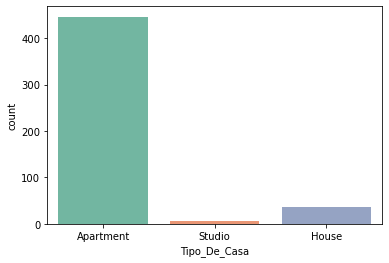

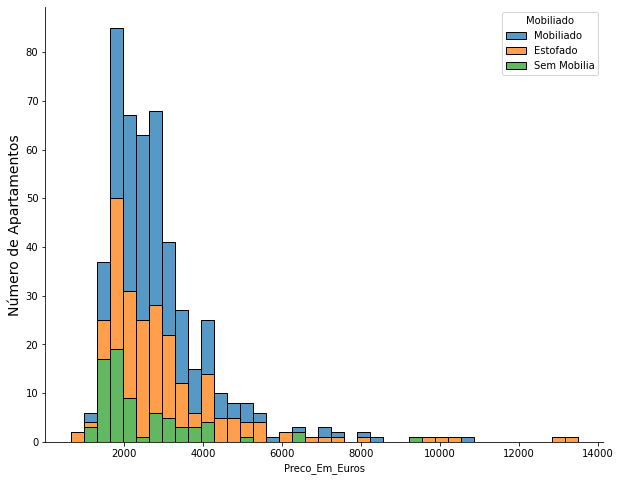

In [33]:
display(casas)
casas.info()

f
sns.countplot(x='Tipo_De_Casa', palette='Set2', data=casas)

fig, ax = plt.subplots(figsize=(10,8))
sns.despine(fig)
plt.ylabel('Número de Apartamentos', fontsize=14)

sns.histplot(data=casas, x='Preco_Em_Euros', hue='Mobiliado', multiple='stack')

<AxesSubplot:xlabel='Preco_Em_Euros', ylabel='Número de Apartamentos'>

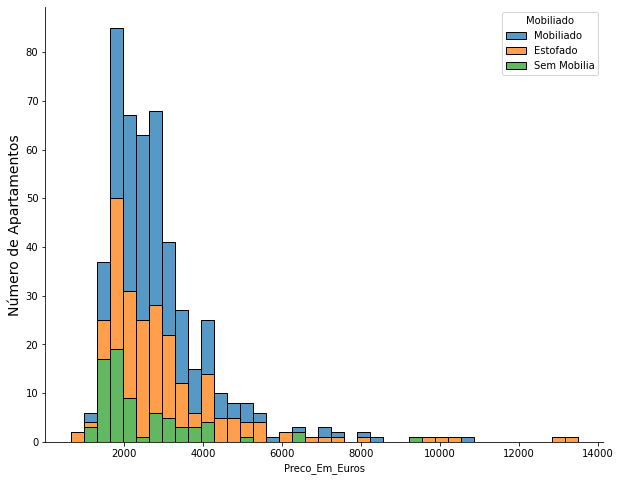

In [32]:
fig, ax = plt.subplots(figsize=(10,8))
sns.despine(fig)
plt.ylabel('Número de Apartamentos', fontsize=14)

sns.histplot(data=casas, x='Preco_Em_Euros', hue='Mobiliado', multiple='stack')

In [38]:
#Oito localizações com mais lugares a venda
((casas.value_counts('Localizacao_Do_Imovel', normalize=True)) * 100).nlargest(8)

Localizacao_Do_Imovel
Museumkwartier         5.102041
Grachtengordel-West    4.693878
Jordaan                4.693878
Apollobuurt            4.693878
Noordelijke            4.081633
Grachtengordel-Zuid    3.673469
Scheldebuurt           3.469388
Nieuwmarkt/Lastage     3.061224
dtype: float64

In [48]:
#As localizações com as médias mais caras para se morar
casas.drop(
    columns=['Numero_Do_Imovel']).groupby(
    by='Localizacao_Do_Imovel').mean().astype(int).sort_values(
    'Preco_Em_Euros', ascending=False)

,Preco_Em_Euros,Tamanho_Do_Imovel_Em_MetrosQuadrados,Numero_De_Quartos
Localizacao_Do_Imovel,,,
Grachtengordel-Zuid,4913,155,3
Omval/Overamstel,4600,132,4
Willemspark,4523,147,4
De,4232,144,3
Museumkwartier,4008,138,4
...,...,...,...
Buikslotermeer,1662,83,3
Bijlmer,1546,78,2
Banne,1500,80,2


# Desenvolvendo o modelo de machine learning

### Separando as colunas para as features e o target